## Statistiques sur les tailles des molécules et suppression des données marginales

Nous avons remarqué lors de la création des jeux de données qu'il existe des molécules vides dans les données, et nous nous doutons que la représentation des molécules de différentes tailles n'est pas uniforme et que le jeu de données contient moins d'exemples de molécules de grande taille.

Dans l'idée de travailler sur un jeu plus propre (contenant moins de données aberrantes) et de travailler sur des molécules plus petites afin de gagner de la mémoire et du temps d'exécution, nous allons créer un nouveau jeu de données contenant les molécules de tailles supérieures ou égales à 2, et inférieures à un certain seuil que nous allons déterminer en analysant la distribution des tailles de molécules dans le jeu.

La taille maximale des molécules que nous retenons est 60. En effet, aucune taille n'est représentée plus de 162 fois au dela de ce seuil, alors que la taille la plus représentée (30) est présente plus de 200000 fois.



#### Recherche de la molécule de plus grande taille

In [9]:
import h5py

riken_data = h5py.File("../data/riken_v2.h5")

anums = riken_data["anums"]

max_len = 0

for anums_mol in anums:
    
    if len(anums_mol) > max_len:
        max_len = len(anums_mol)

print("La taille de la molécule de plus grande taille est : "+str(max_len))



KeyboardInterrupt: 

##### Sortie 

La taille de la molécule de plus grande taille est : 137


#### Distribution des tailles

In [11]:
import h5py
import numpy as np

riken_data = h5py.File("../data/riken_v2.h5")

anums = riken_data["anums"]

np_tailles = np.zeros(shape=(150,))

for anums_mol in anums:
    
    taille = len(anums_mol)
    np_tailles[taille] += 1
    
    


#### Représentation graphique des tailles

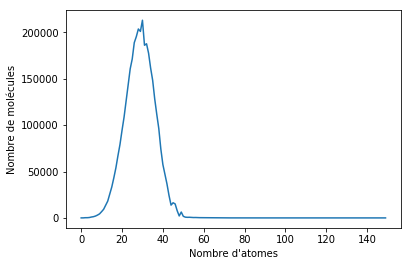

In [12]:
%matplotlib inline  
import matplotlib.pyplot as plt


plt.plot(np_tailles)
plt.ylabel("Nombre de molécules")
plt.xlabel("Nombre d'atomes")
plt.savefig("../figures/8.0_distribution_molécules.png")
plt.show()

#### Tableau des tailles

In [13]:
import pandas as pd

df = pd.DataFrame(np_tailles)

def print_full(x):
    """ Permet d'afficher le tableau entier, solution prise sur 
    https://stackoverflow.com/questions/19124601/is-there-a-way-to-pretty-print-the-entire-pandas-series-dataframe"""
    
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(df)


            0
0        26.0
1        37.0
2       231.0
3       242.0
4       426.0
5       947.0
6      1317.0
7      1997.0
8      3055.0
9      4363.0
10     6743.0
11     9310.0
12    13581.0
13    18102.0
14    25974.0
15    33444.0
16    43319.0
17    53984.0
18    67005.0
19    79186.0
20    94375.0
21   108665.0
22   126069.0
23   143721.0
24   160675.0
25   171388.0
26   188952.0
27   195435.0
28   203662.0
29   201038.0
30   213096.0
31   186110.0
32   187751.0
33   177544.0
34   161574.0
35   148329.0
36   128365.0
37   111839.0
38    96358.0
39    74291.0
40    57552.0
41    47343.0
42    36655.0
43    24208.0
44    13807.0
45    16335.0
46    15086.0
47     7778.0
48     2134.0
49     6320.0
50     1754.0
51      819.0
52      645.0
53      695.0
54      555.0
55      407.0
56      443.0
57      338.0
58      280.0
59      256.0
60      213.0
61      162.0
62      140.0
63      127.0
64      103.0
65       65.0
66       78.0
67       44.0
68       47.0
69       39.0
70    

##### Suppression des données marginales

On va ici chercher à réduire le jeu de données aux molécules ayant les tailles les plus représentées, et les tailles les plus utiles pour l'apprentissage des modèles. En effet, les molécules de tailles 0 ou 1 n'ont pas d'intérêt pour nous, et les molécules de tailles trop importantes (supérieure à 60) sont peu représentées et ne constituent donc pas suffisamment d'exemples pour entraîner un RN efficace pour ces tailles.

In [14]:
import h5py
import time
import numpy as np

def creation_jeu_reduit(original_dataset_location, reduced_dataset_location):
    
    start_time = time.time()    

    
    # On créé les jeux de données
    riken_original = h5py.File(original_dataset_location, 'r')
    riken_reduced = h5py.File(reduced_dataset_location, 'w')

    # On calcule le nombre d'exemples à garder du jeu initial
    taille_reduced = np.sum(np_tailles[2:60])

    try:
        # On créé les nouveaux datasets
        varlen_floatarray = h5py.special_dtype(vlen=np.dtype("float32"))
        
        pubchem_id = riken_reduced.create_dataset("pubchem_id", shape=(taille_reduced,), dtype=np.int32,
                                                  compression='gzip', chunks=True)

        anums = riken_reduced.create_dataset("anums", shape=(taille_reduced,), dtype=varlen_floatarray,
                                            compression='gzip', chunks=True)

        amasses = riken_reduced.create_dataset("amasses", shape=(taille_reduced,), dtype=varlen_floatarray,
                                            compression='gzip', chunks=True)

        riken_coords = riken_reduced.create_dataset("riken_coords", shape=(taille_reduced,), 
                                                    dtype=varlen_floatarray, compression='gzip', chunks=True)


        # On créé les nouveaux datasets en itérant sur les datasets existants
        original_size = len(riken_original["pubchem_id"])
        reduced_idx = 0
        for original_idx in range(original_size):
            
            if (original_idx%100000 == 0):
                print("Traitement molécule "+str(original_idx))
            
            # On ne traite que les molécules de taille acceptable
            curr_len = len(riken_original["anums"][original_idx])
            if curr_len >= 2 and curr_len <=60:
                
                # On enregistre les informations de la molécule
                pubchem_id[reduced_idx] = riken_original["pubchem_id"][original_idx]
                anums[reduced_idx] = riken_original["anums"][original_idx]
                amasses[reduced_idx] = riken_original["amasses"][original_idx]
                riken_coords[reduced_idx] = riken_original["riken_coords"][original_idx]
                reduced_idx += 1
                
        riken_reduced.flush()
        
        print("--- %s seconds ---" % (time.time() - start_time))


    finally:
        riken_original.close()
        riken_reduced.close()


In [16]:
print("Création jeu réduit")
#creation_jeu_reduit("../data/riken_v2.h5", "../data/riken_v2_reduced.h5")
creation_jeu_reduit("../data/mini_set.h5", "../data/mini_set_reduced.h5")

Création jeu réduit
Traitement molécule 0
--- 0.013207197189331055 seconds ---


#### Représentation graphique du nouveau jeu de données

In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt
import h5py
import numpy as np

riken_data = h5py.File("../data/riken_v2_reduced.h5")

anums = riken_data["anums"]

np_tailles = np.zeros(shape=(150,))

for anums_mol in anums:
    
    taille = len(anums_mol)
    np_tailles[taille] += 1
    
    
plt.plot(np_tailles)
plt.ylabel("Nombre de molécules")
plt.xlabel("Nombre d'atomes")
plt.savefig("../figures/8.0_distribution_molécules_post_reduction.png")
plt.show()

#### Tableau des tailles des nouvelles données

In [1]:
import pandas as pd

df = pd.DataFrame(np_tailles)

def print_full(x):
    """ Permet d'afficher le tableau entier, solution prise sur 
    https://stackoverflow.com/questions/19124601/is-there-a-way-to-pretty-print-the-entire-pandas-series-dataframe"""
    
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(df)


NameError: name 'np_tailles' is not defined